In [6]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error',
          'r2' : 'r2'} 

In [8]:
df = pd.read_csv("/Users/rodrigo/Post-Grad/Ising_GNN/Data/result.csv").dropna().set_index(['Institution','Subject', 'Run'])
merged_df,merged_phenotypic  = read_motion()
merged_phenotypic = merged_phenotypic.reset_index()
merged_phenotypic['Run'] = merged_phenotypic['Run'].astype('int64')
merged_phenotypic['Subject'] = merged_phenotypic['Subject'].astype('int64')

merged_phenotypic = merged_phenotypic.set_index(['Institution','Subject', 'Run'])


merged_phenotypic = merged_phenotypic[merged_phenotypic.index.isin(df.index)]

df[' Max Rotation (degree)'] = merged_phenotypic[' Max Rotation (degree)'] 
df['Max Motion (mm)'] = merged_phenotypic['Max Motion (mm)'] 




df.head()

df = df[df['Max Motion (mm)'] < 1]
df = df[df[' Max Rotation (degree)'] < 1]
df = df[df['DX'] == 0.0]

/Users/rodrigo/Post-Grad/Ising_GNN/utils.py:356: FutureWarning: The default value of regex will change from True to False in a future version.
  motion['Subject'] = motion['Subject'].str.replace(r'^(0+)', '').fillna('0')


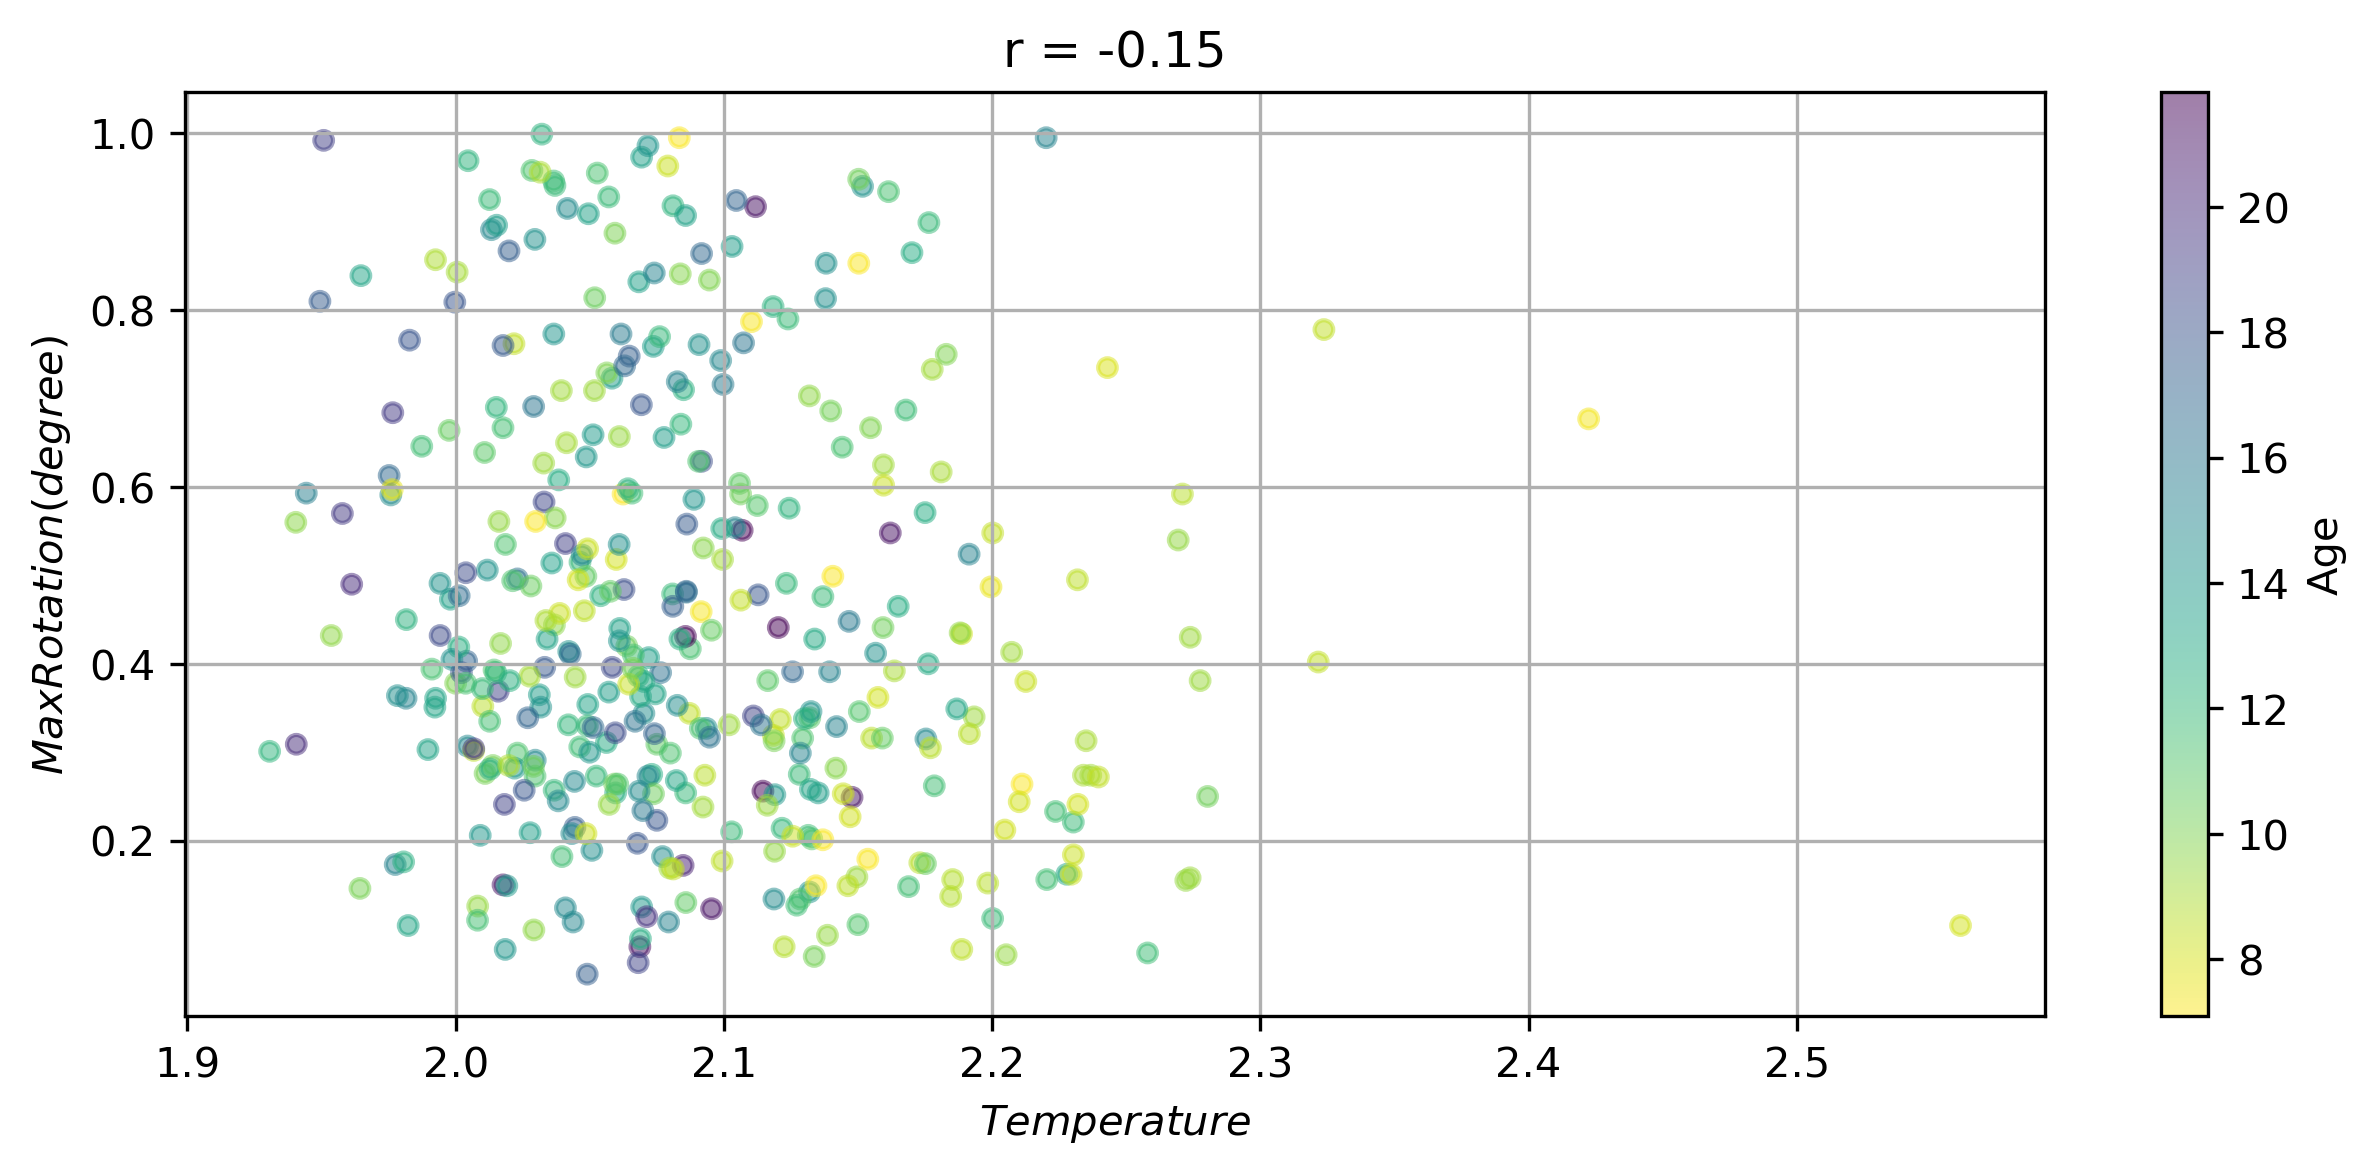

In [9]:

plt.figure(figsize=(10,4),dpi=300)

plt.scatter(pd.DataFrame(df['Temperature']),pd.DataFrame(df[' Max Rotation (degree)']),
            c=df['Age'], cmap='viridis_r', alpha=0.5, s=20)
plt.title('r = {:.2f}'.format(np.corrcoef(df['Temperature'], df[' Max Rotation (degree)'])[0][1]))
plt.colorbar(label='Age')
plt.xlabel(r'$Temperature$')
plt.ylabel(r'$ Max Rotation (degree)$')
#plt.xlim(1.8,2.5)
#plt.ylim(1.8,2.5)
plt.grid()

plt.show()

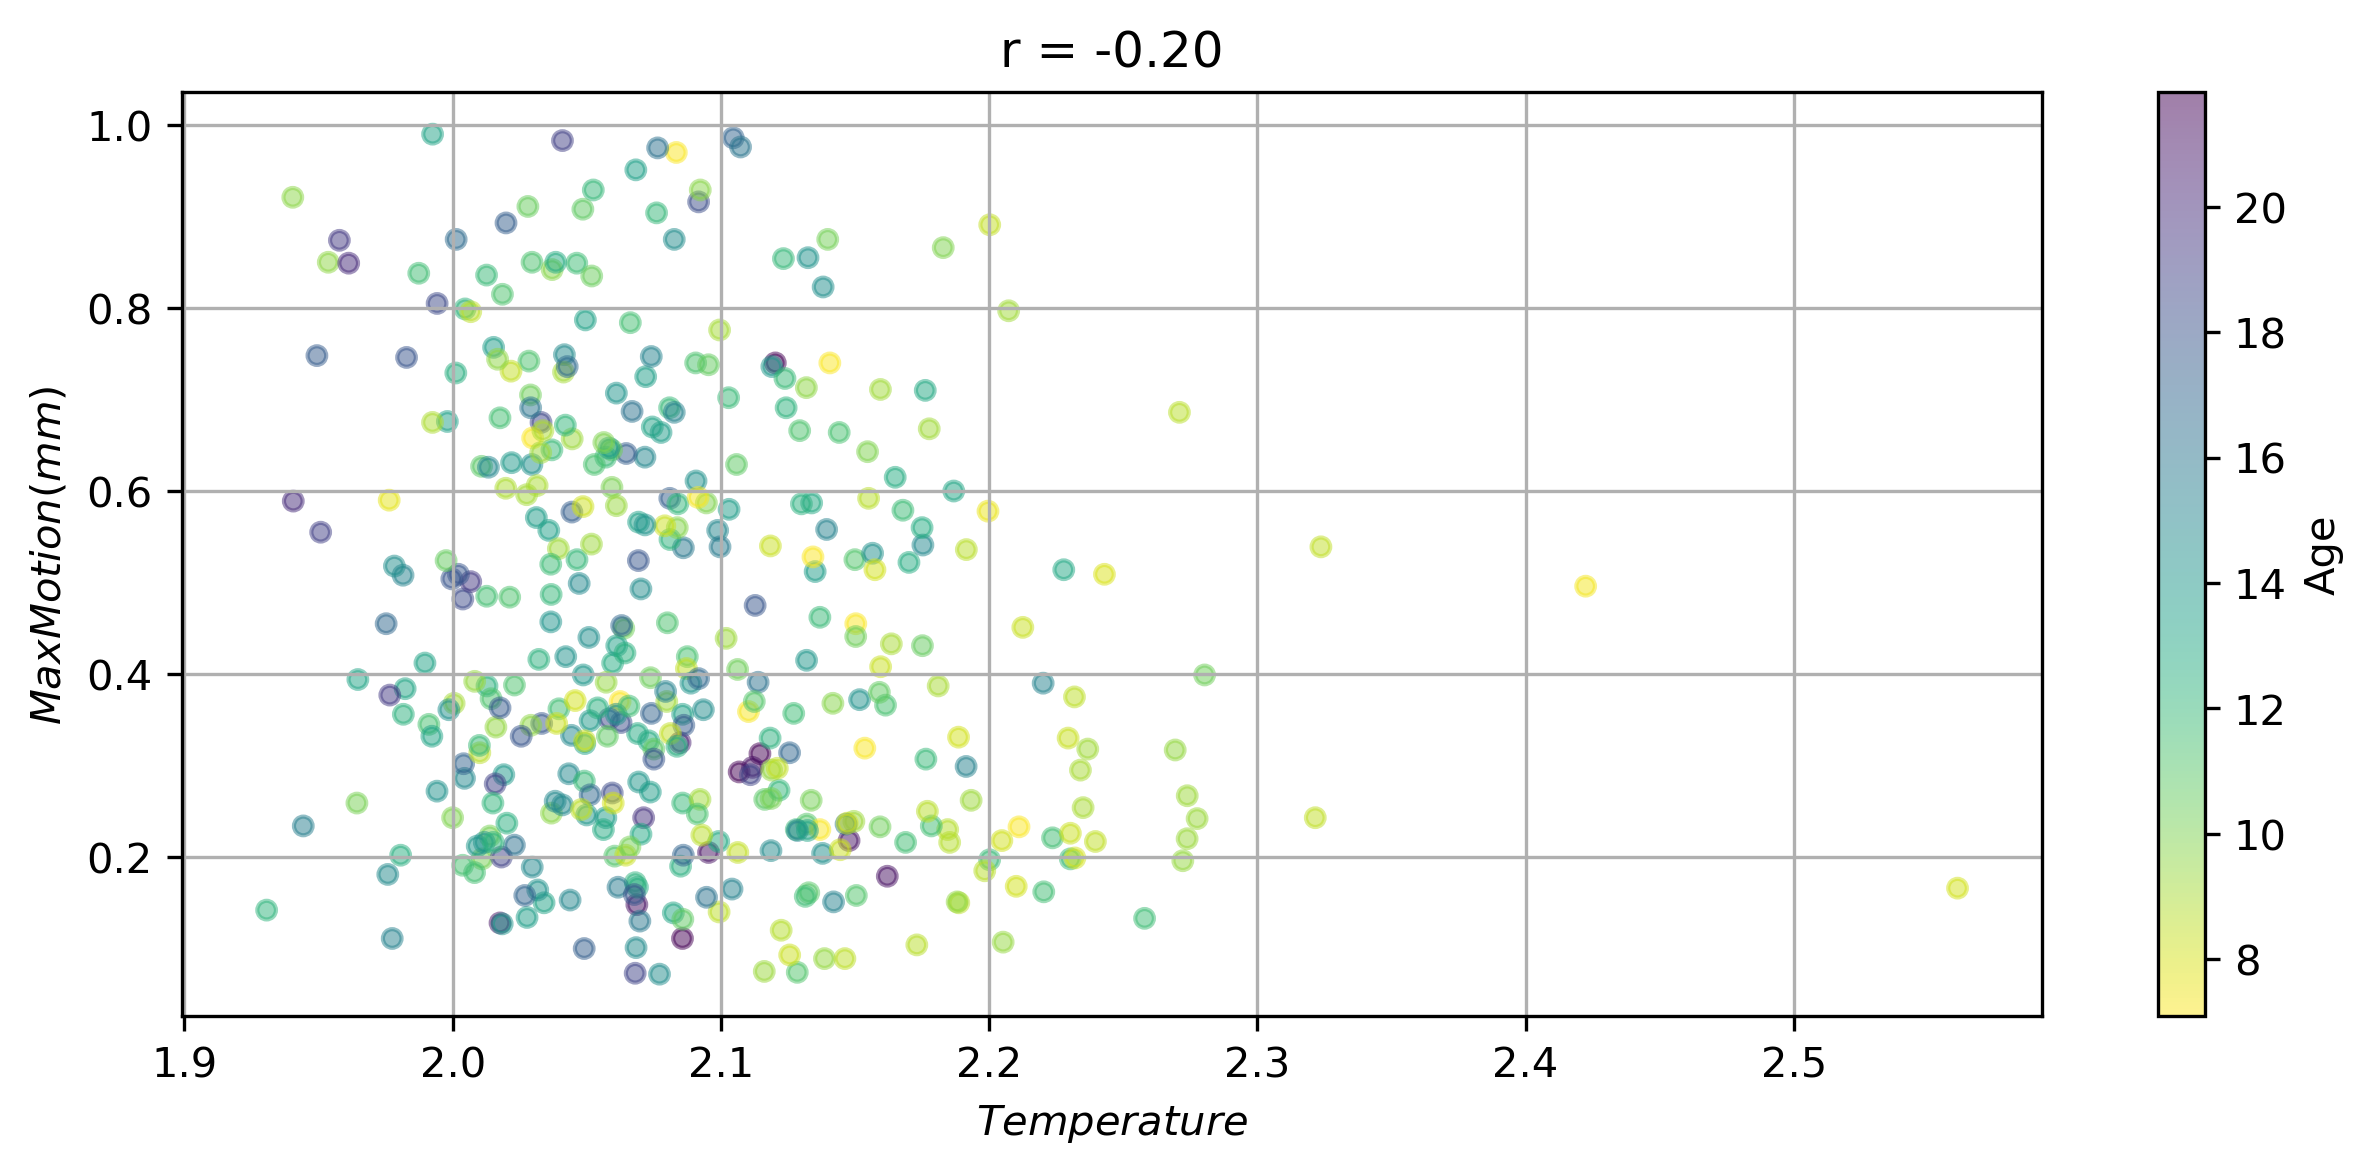

In [10]:
plt.figure(figsize=(10,4),dpi=300)

plt.scatter(pd.DataFrame(df['Temperature']),pd.DataFrame(df['Max Motion (mm)']),
            c=df['Age'], cmap='viridis_r', alpha=0.5, s=20)
plt.title('r = {:.2f}'.format(np.corrcoef(df['Temperature'], df['Max Motion (mm)'])[0][1]))
plt.colorbar(label='Age')
plt.xlabel(r'$Temperature$')
plt.ylabel(r'$Max Motion (mm)$')
#plt.xlim(1.8,2.5)
#plt.ylim(1.8,2.5)
plt.grid()

plt.show()

In [11]:
print('correlation Temperature and Age = {}'.format(np.corrcoef([df['Temperature'], df['Age']])[0,1]))

correlation Temperature and Age = -0.3469410058950905


In [12]:
print('correlation Temperature and Max Motion = {}'.format(np.corrcoef([df['Temperature'], df['Max Motion (mm)']])[0,1]))

correlation Temperature and Max Motion = -0.19526981256914236


In [13]:
# X = df[['Age', 'Max Motion (mm)']]#, 'Gender', 'DX']]
# y = df['Temperature']

X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Temperature', 'Gender']] # 'DX'
y = df['Age']

#X['Max Motion (mm)'] = np.log(X['Max Motion (mm)']) + 0.00001

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

In [14]:
# plt.hist(X.Age, alpha=0.5)
# plt.hist(X['Max Motion (mm)'], alpha=.5)
# plt.hist(y, alpha=.6)
# plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True).fit(X,y)
reg.score(X, y)

# from sklearn.model_selection import cross_val_score
# scores = cross_validate(reg, X, y, cv=2 ,scoring=scoring, n_jobs=-1)
# print('mae', scores['test_mae'].mean())
# print('r2', scores['test_r2'].mean())

0.12854897590206527

In [16]:
reg.intercept_

0.5645310087986213

In [17]:
reg.coef_

array([-0.07681676,  0.0378132 , -0.67578351, -0.0233138 ])

In [18]:
import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()


In [19]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     14.57
Date:                Sun, 19 May 2024   Prob (F-statistic):           4.16e-11
Time:                        09:18:17   Log-Likelihood:                 40.990
No. Observations:                 400   AIC:                            -71.98
Df Residuals:                     395   BIC:                            -52.02
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.5645      0.037     15.234      0.000       0.492       0.637
Max Motion (mm)           -0.0768      0.051     -1.501      0.134      -0.177       0.024
 Max Rotation (degree)     0.0378      0.050      0.754      0.451      -0.061       0.136
Temperature               -0.6758      0.091     -7.458      0.000      -0.854      -0.498
Gender                    -0.0233      0.022     -1.056      0.292      -0.067       0.020
==============================================================================
Omnibus:                       21.698   Durbin-Watson:                   0.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.958
Skew:                           0.597   Prob(JB):                     6.27e-06
Kurtosis:                       3.113   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.inspection import permutation_importance


svm = svm.SVR(kernel='rbf',C=1)
svm.fit(X,y)
svm.score(X,y)

# from sklearn.model_selection import cross_val_score
# scores = cross_validate(svm, X, y, cv=5 ,scoring=scoring, n_jobs=-1)
# print('mae', scores['test_mae'].mean())
# print('r2', scores['test_r2'].mean())


0.16367029514102027

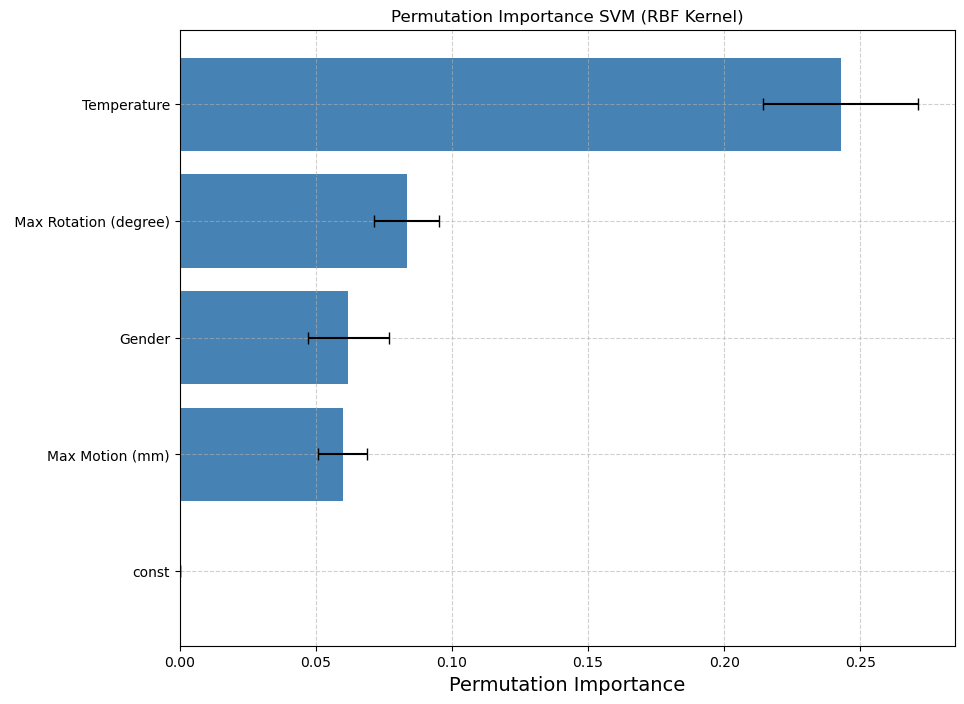

In [21]:
perm_importance = permutation_importance(svm, X, y)
feature_names = X.columns.values
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()



# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx],
         xerr=perm_importance.importances_std[sorted_idx], color='steelblue', ecolor='black', capsize=4)
plt.xlabel("Permutation Importance", size=14)
plt.title("Permutation Importance SVM (RBF Kernel)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [22]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators= 100, max_depth=2, random_state=42)
regr.fit(X, y)
regr.score(X,y)

# scores = cross_validate(regr, X, y, cv=10 ,scoring=scoring, n_jobs=-1)
# print('mae', scores['test_mae'].mean())
# print('r2', scores['test_r2'].mean())

0.18725596776924436

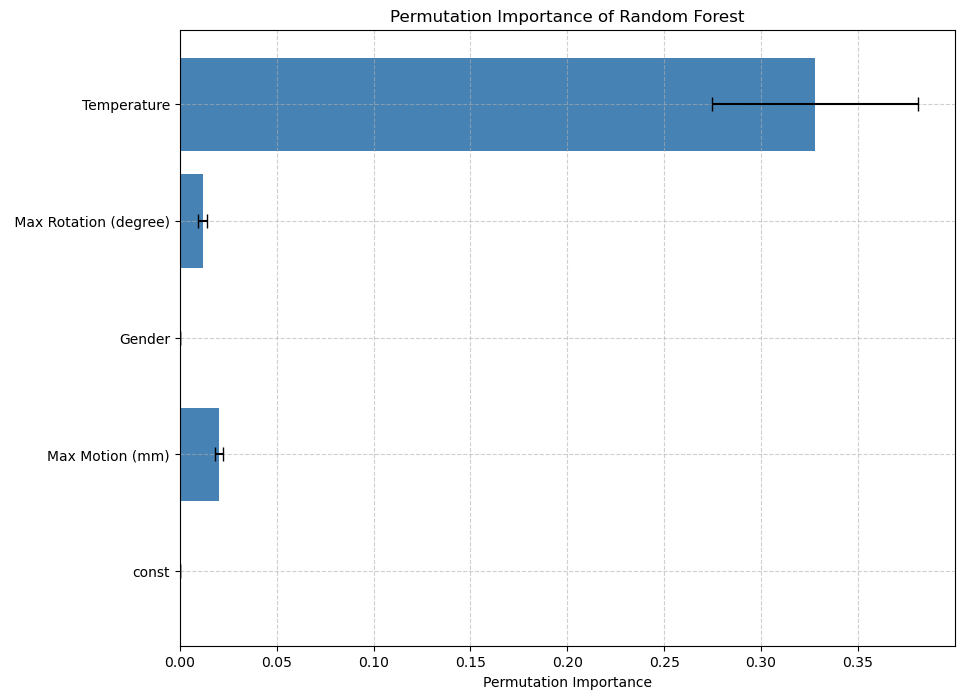

In [23]:
perm_importance = permutation_importance(regr, X, y)

feature_names = X.columns.values
features = np.array(feature_names)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx],
         xerr=perm_importance.importances_std[sorted_idx], color='steelblue', ecolor='black', capsize=5)
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Random Forest")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

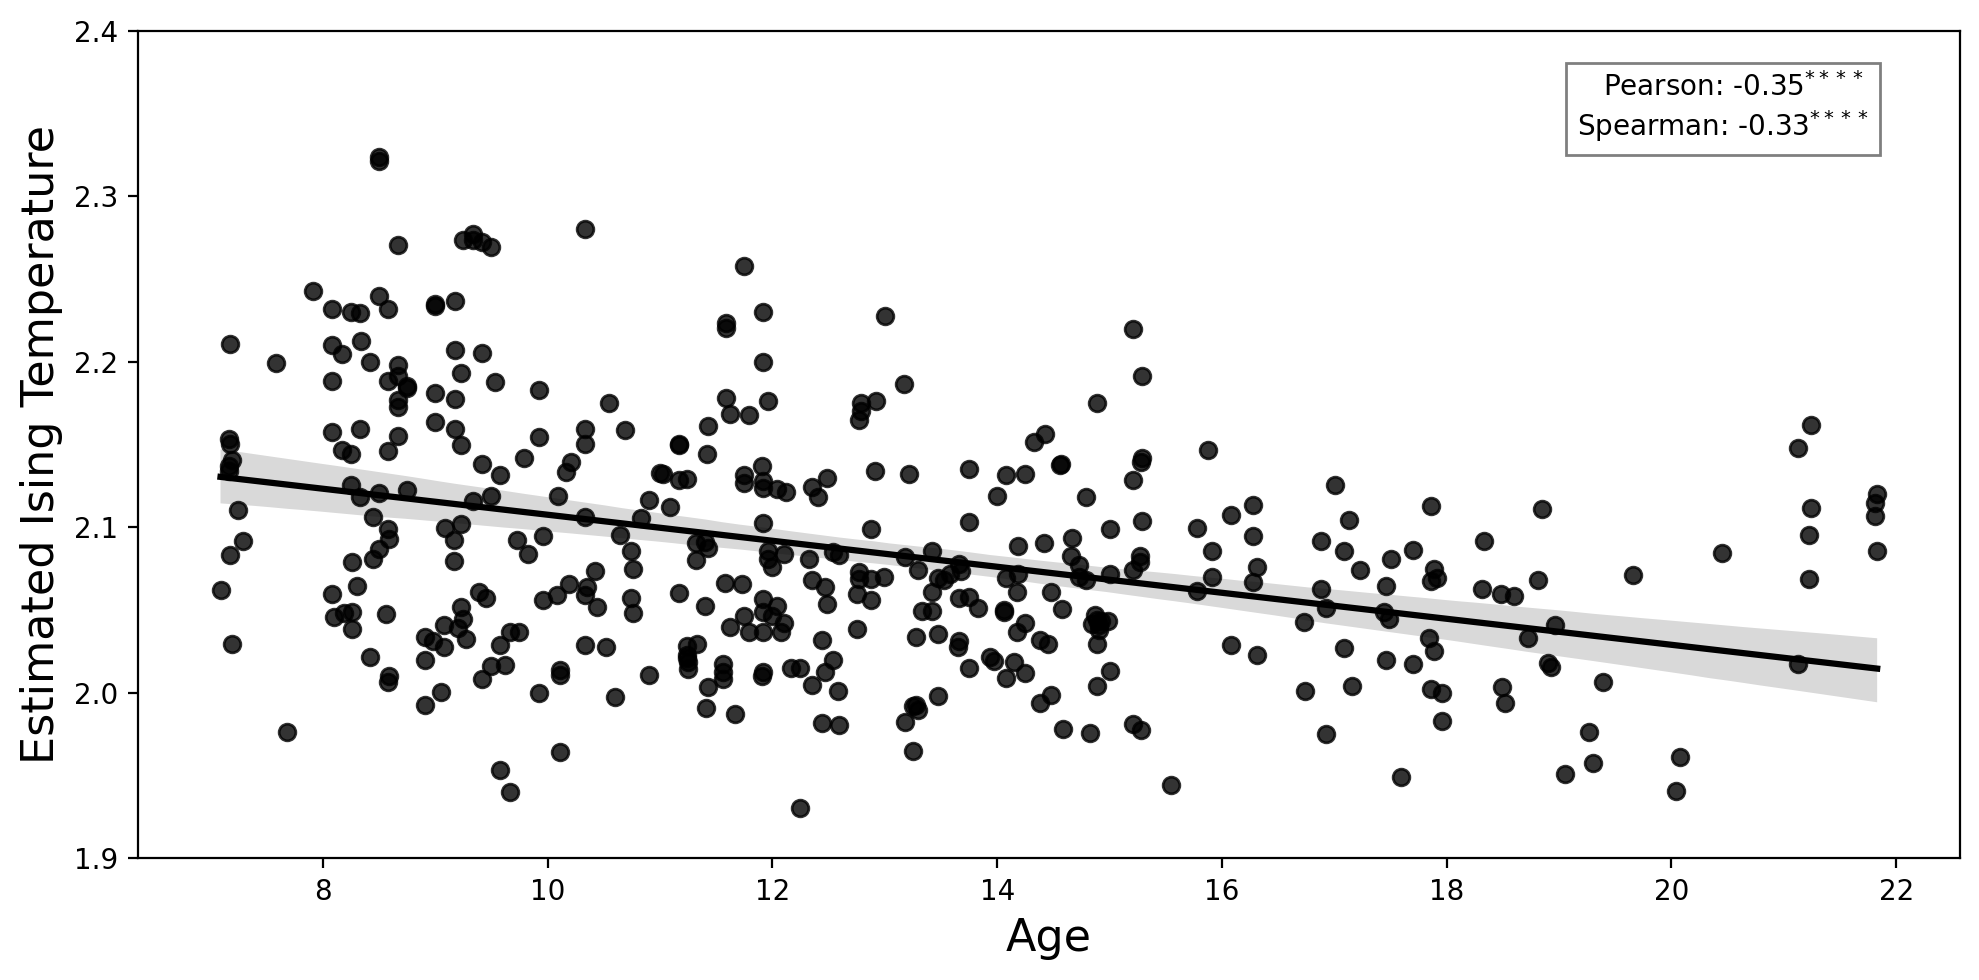

In [24]:
from scipy import stats

plt.figure(figsize=(10,5),dpi=200)
sns.regplot(data=df, x='Age', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Temperature'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{****}}$ \nSpearman: {spearman:.2f}$^{{****}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.ylim(1.9, 2.4)
plt.ylabel('Estimated Ising Temperature', size=16)
plt.xlabel(r'Age', size=16)
plt.tight_layout()
plt.show()